In [1]:
import numpy as np
import pandas as pd
import pprint
import pickle
pp = pprint.PrettyPrinter(indent=1)
BOARD_ROWS = 3
BOARD_COLS = 3
# Adapted from https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/TicTacToe/ticTacToe.py


/tmp/ipykernel_46092/2712690755.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [51]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play_train(self, rounds=100):
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # self.showBoard()
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    # play with human
    def play2(self,display=False):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol,explore=False)
            # take action and upate board state
            self.updateState(p1_action)
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    if display:
                        self.showBoard()
                    self.reset()
                    return self.p1.name
                else:
                    if display:
                        self.showBoard()
                    self.reset()
                    return 0
                break

            else:
                # Player 2
                self.showBoard()
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions,self.board,self.playerSymbol,explore=False)

                self.updateState(p2_action)
                # self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        self.reset()
                        if display:
                            self.showBoard()
                        return self.p2.name
                    else:
                        if display:
                            self.showBoard()
                        self.reset()
                        return 0
                    break
            if display:
                self.showBoard()

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')



In [35]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol,explore=True):
        if explore and np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [49]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions,board,player_symbol=1,explore=False):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action
            else:
                print("Invalid Action")

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass


In [41]:
class RandomPlayer(Player):
    def chooseAction(self, positions, current_board, symbol,explore =True):
        # return super().chooseAction(positions, current_board, symbol)
        idx = np.random.choice(len(positions))
        return positions[idx]

In [52]:
p1 = Player("q_player")
# p2 = Player("rand_player")
p2 = HumanPlayer("Human")
# p2 = RandomPlayer('Random')
p1.loadPolicy('policy_p1_vs_q')
# p2.loadPolicy('policy_p1_vs_q')
st = State(p1, p2)
# print("training...")
# st.play_train(50000)
# p1.savePolicy()
st.play2(display=True)
# st.showBoard()

-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   | x | 
-------------
|   | o |   | 
-------------
|   |   | x | 
-------------
-------------
|   |   | x | 
-------------
|   | o | o | 
-------------
|   |   | x | 
-------------
-------------
|   |   | x | 
-------------
| x | o | o | 
-------------
|   |   | x | 
-------------
-------------
| o |   | x | 
-------------
| x | o | o | 
-------------
|   |   | x | 
-------------
-------------
| o |   | x | 
-------------
| x | o | o | 
-------------
|   | x | x | 
-------------
-------------
| o |   | x | 
-------------
| x | o | o | 
-------------
| o | x | x | 
-------------
-------------
| o | x | x | 
-------------
| x | o | o | 
-------------
| o | x | x | 
-------------


0

In [45]:
st.showBoard()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


In [25]:
from tqdm.auto import tqdm
NUM_TRIALS = 50000
winners = []
for i in tqdm(range(NUM_TRIALS)):
    winners.append(st.play2())



  0%|          | 0/50000 [00:00<?, ?it/s]

In [26]:
nms, wins = np.unique(winners,return_counts=True)



<BarContainer object of 1 artists>

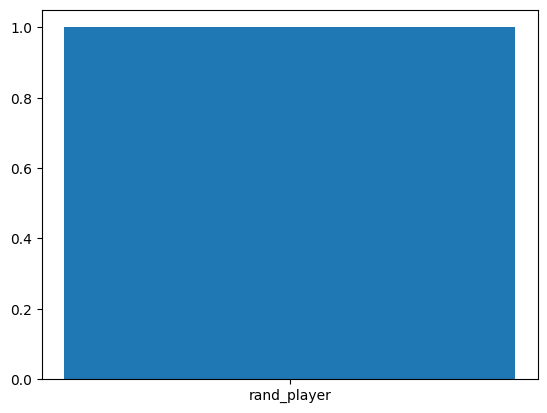

In [27]:
from matplotlib import pyplot as plt

plt.bar(nms,[w / np.sum(wins) for w in wins])